<a href="https://colab.research.google.com/github/mshakerinava/IFT6269-A20-proj6/blob/main/ift_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive') 
image_path = '/content/drive/My Drive/ift6269-project/figures/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


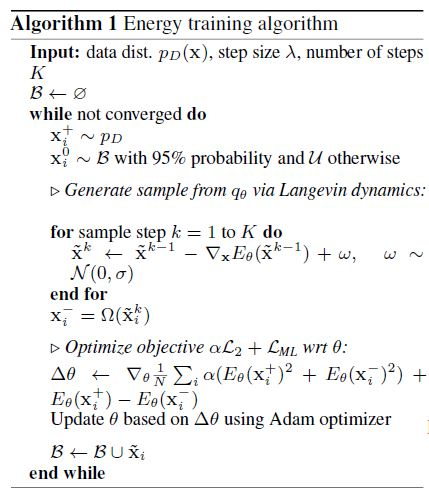

Models

In [2]:
class Identity(nn.Module):
  def forward(self, input, *args, **kwargs):
    return input

In [3]:
class Conditional_InstanceNorm(torch.nn.Module):
  # Code from https://github.com/kewellcjj/pytorch-multiple-style-transfer/pull/5 (modified)
    def __init__(self, num_features, num_classes):
        super(Conditional_InstanceNorm, self).__init__()
        self.num_features = num_features
        self.inst_norm = torch.nn.InstanceNorm2d(num_features, affine=False)
        #self.gamma = nn.parameter.Parameter(torch.FloatTensor(num_classes, num_features)).data.normal_(1, 0.02) # Initialise scale at N(1, 0.02)
        #self.beta = nn.parameter.Parameter(torch.FloatTensor(num_classes, num_features)).data.zero_() # Initialise bias at 0
        self.embed1 = torch.nn.Embedding(num_classes, num_features)
        self.embed2 = torch.nn.Embedding(num_classes, num_features)
        self.embed1.weight.data.normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
        self.embed2.weight.data.zero_()  # Initialise bias at 0

    def forward(self, x, y):
        out = x#self.inst_norm(x)
        gamma = self.embed1(y)
        beta = self.embed2(y)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out


In [4]:
class ResBlock(nn.Module):
  def __init__(self, in_size, out_size, num_classes, stride=1):
      super(ResBlock, self).__init__()

      self.conditional_layer1 = Identity()
      self.conditional_layer2 = Identity()
      self.conditional_layer3 = Identity()

      if num_classes is not None:
        self.conditional_layer1 = Conditional_InstanceNorm(out_size, num_classes)
        self.conditional_layer2 = Conditional_InstanceNorm(out_size, num_classes) 

      self.stride = stride
      self.conv_block1 = nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1)
      self.conv_block2 = nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1)
      self.avgPool = nn.AvgPool2d(kernel_size=stride, stride=stride)

      self.shortcut = Identity()

      if in_size != out_size:
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, stride=1)
        if num_classes is not None:
          self.conditional_layer3 = Conditional_InstanceNorm(out_size, num_classes)

  def forward(self, x, y=None):
      if self.stride > 1:
          x = self.avgPool(x)
      out_block = self.conv_block1(x)
      out_block = self.conditional_layer1(out_block, y)
      out_block = F.leaky_relu(out_block)

      out_block = self.conv_block2(out_block)
      out_block = self.conditional_layer2(out_block, y)
      out_block = F.leaky_relu(out_block)

      out_block =  out_block + self.conditional_layer3(self.shortcut(x),y)

      return out_block

In [5]:
def res_block_layers(in_size, out_size, num_res_block, num_classes=None, stride=1):
    layers = []

    #append the first layer
    layers.append(ResBlock(in_size, out_size, num_classes, stride))

    #append the remaining layers
    for i in range(1, num_res_block):
        layers.append(ResBlock(out_size, out_size, num_classes))

    return nn.Sequential(*layers)

In [6]:
class ResNet(nn.Module):
    def __init__(self, in_dim=1, num_classes=None):
      super(ResNet, self).__init__()

      self.conditional_layer = Identity()
      if num_classes is not None:
        self.conditional_layer = Conditional_InstanceNorm(32, num_classes) 

      self.in_dim = in_dim
      self.conv = nn.Conv2d(in_dim, 32, kernel_size=3, stride=1, padding=3)

      self.res_block1_1 = ResBlock(32, 64, num_classes, stride=2)
      self.res_block1_2 = ResBlock(64, 64, num_classes)
      self.res_block1_3 = ResBlock(64, 64, num_classes)

      self.res_block2_1 = ResBlock(64, 128, num_classes, stride=2)
      self.res_block2_2 = ResBlock(128, 128, num_classes)
      self.res_block2_3 = ResBlock(128, 128, num_classes)

      self.res_block3_1 = ResBlock(128, 256, num_classes, stride=2)
      self.res_block3_2 = ResBlock(256, 256, num_classes)
      self.res_block3_3 = ResBlock(256, 256, num_classes)

      self.linear = nn.Linear(256, 1)

    def forward(self, x, y=None):
        x = self.conv(x)
        #x = self.conditional_layer(x, y) #only mention using for res layers
        x = F.leaky_relu(x)

        #residual blocks
        x = self.res_block1_1(x, y)
        x = self.res_block1_2(x, y)
        x = self.res_block1_3(x, y)

        x = self.res_block2_1(x, y)
        x = self.res_block2_2(x, y)
        x = self.res_block2_3(x, y)

        x = self.res_block3_1(x, y)
        x = self.res_block3_2(x, y)
        x = self.res_block3_3(x, y)

        # x.shape == [BATCH_SIZE, 256, 4, 4]
        x = torch.sum(x, dim=[2, 3])
        x = self.linear(x)
        return x

In [7]:
BATCH_SIZE = 128
MAX_BUFFER_SIZE = 10000
learning_rate = 1e-4
alpha = 1e-3
sigma = 0.005
lambdaa = 10.
K = 60 # Number of Langevin Dynamics steps

In [83]:
DATASET = "MNIST"
mnist_transform =torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test =  MNIST(root='./data', train=False, download=True, transform=mnist_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1) # REMARK: we don't need test data!

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
B = []
input_size = 28*28
output_size = 1

cuda:0


In [10]:
def sample(net, B, shape, lmbda, sigma, device, y=None, n_steps=K, x0=None):
    ''' samples a batch of images with Langevin dynamics '''
    # Get our `x0` either from uniform noise or reply buffer
    shape = list(shape)
    if x0 is None:
        if len(B) == 0:
            x0 = torch.rand(*shape, device=device)
        else:
            x0 = torch.where(
                (torch.rand(shape[0], device=device) > 0.95)[:, None, None, None],
                torch.rand(*shape, device=device),
                torch.cat(np.random.choice(B, size=shape[0]).tolist(), dim=0).to(device))

    x = x0
    x = x.detach()
    x.requires_grad = True
    for k in range(n_steps):
        w = torch.normal(torch.zeros(shape, device=device), sigma * torch.ones(shape, device=device))
        outputs = torch.sum(net(x, y))
        grad = torch.autograd.grad(outputs=outputs, inputs=x)[0]
        grad_clipped = torch.clip(grad, -0.01, +0.01)
        x = x - (lmbda/2) * grad_clipped + w
        x = x.detach()
        x.requires_grad = True
        x = torch.clip(x, 0, 1)
    return x


def loss_fcn(net, x_pos, x_neg, alpha, y=None):
    loss_pos = torch.mean(alpha*(net(x_pos, y)**2) + net(x_pos, y))
    loss_neg = torch.mean(alpha*(net(x_neg, y)**2) - net(x_neg, y))
    return (loss_pos + loss_neg) / 2
    # return torch.mean(alpha*(net(x_pos)**2 + net(x_neg)**2) + net(x_pos) - net(x_neg))

In [ ]:
CONDITIONAL = False
num_classes = None
if CONDITIONAL:
    num_classes = 10
net = ResNet(in_dim=1, num_classes=num_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.0, 0.999)) 


B = []
n_epochs = 3
train_load_iter = iter(train_loader)

for epoch in range(n_epochs):
    total_loss = 0
    
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader), position=0, leave=True) 

    for i, data in progress:
        x_pos, labels = data[0].to(device), data[1].to(device, dtype=torch.int64)
        x_neg = sample(net, B, x_pos.shape, lambdaa, sigma, device, y=labels).detach()
        B += torch.split(x_neg, 1, dim=0)
        B = B[-MAX_BUFFER_SIZE:]
        optimizer.zero_grad()
        loss = loss_fcn(net, x_pos, x_neg, alpha, labels)
        # TODO: clip gradients?
        # param_norm = nn.utils.clip_grad_norm_(net.parameters(), 100)
        # print('‖W‖ =', param_norm.item())
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
  
    model_path = "/content/drive/My Drive/ift6269-project/models/"
    cond_str = "conditional" if CONDITIONAL else "unconditional"
    model_filename = "{}_{}_model_classes_epoch_{}.pt".format(DATASET, cond_str, epoch)
    torch.save({
         'epoch': epoch,
         'model_state_dict': net.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'loss': total_loss,
     }, model_path+model_filename)


Loss: 0.0010:  38%|███▊      | 179/469 [08:44<14:03,  2.91s/it]

/content/drive/My Drive/ift6269-project/models/model_1.pt


### Loading Models

In [ ]:
loaded_net = ResNet().to(device)
loaded_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.0, 0.999)) 

checkpoint = torch.load(model_path)
loaded_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

tensor(0.0461, device='cuda:0', grad_fn=<DivBackward0>)


### Random Buffer Samples

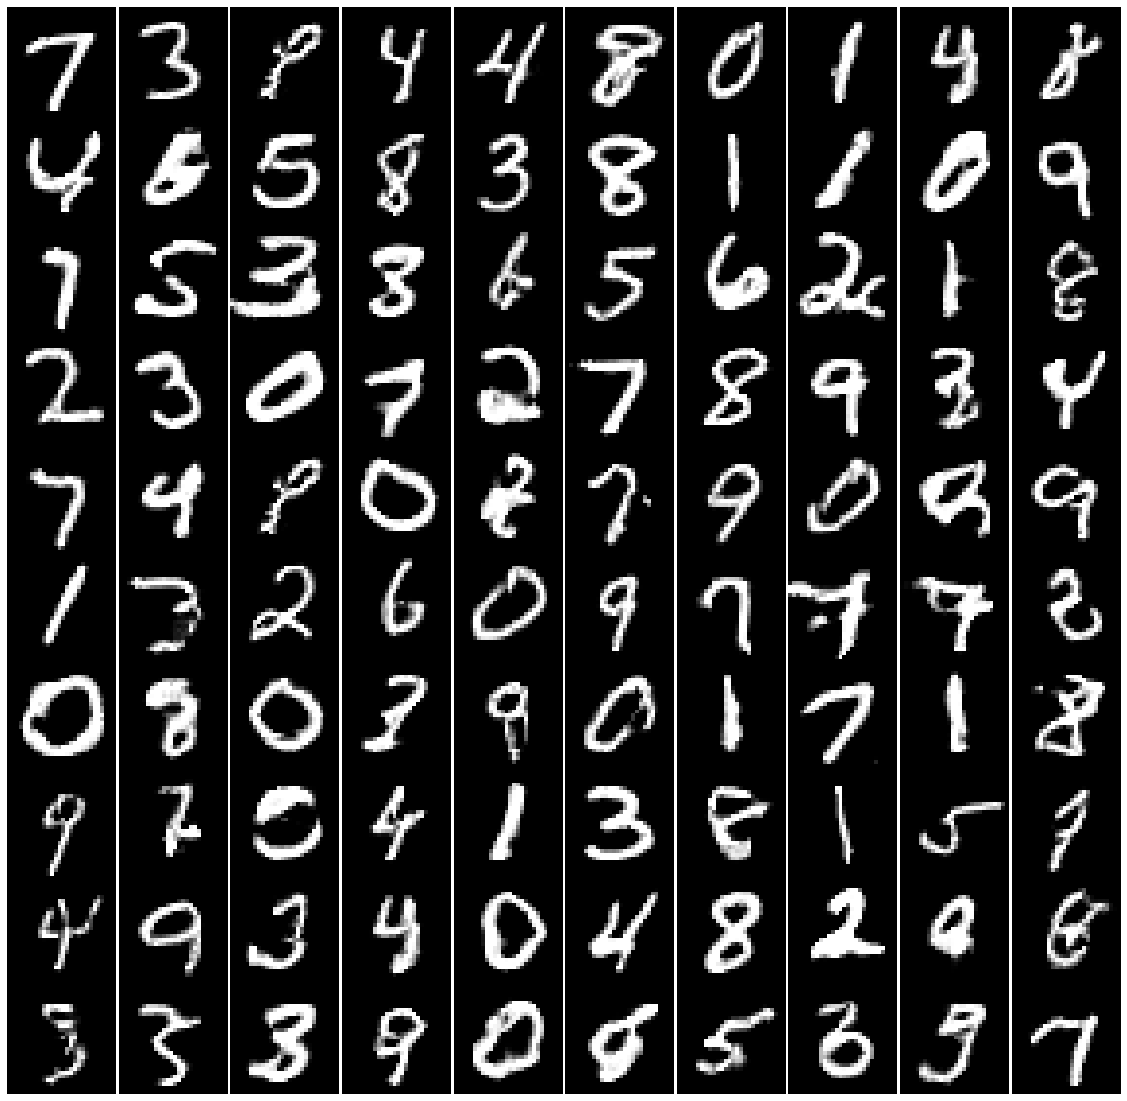

In [12]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        idx = np.random.randint(len(B))
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(B[idx].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig(image_path + 'ebm_mnist_buffer_.png', bbox_inches='tight', dpi=300)

### Increased Sampling Steps per Class

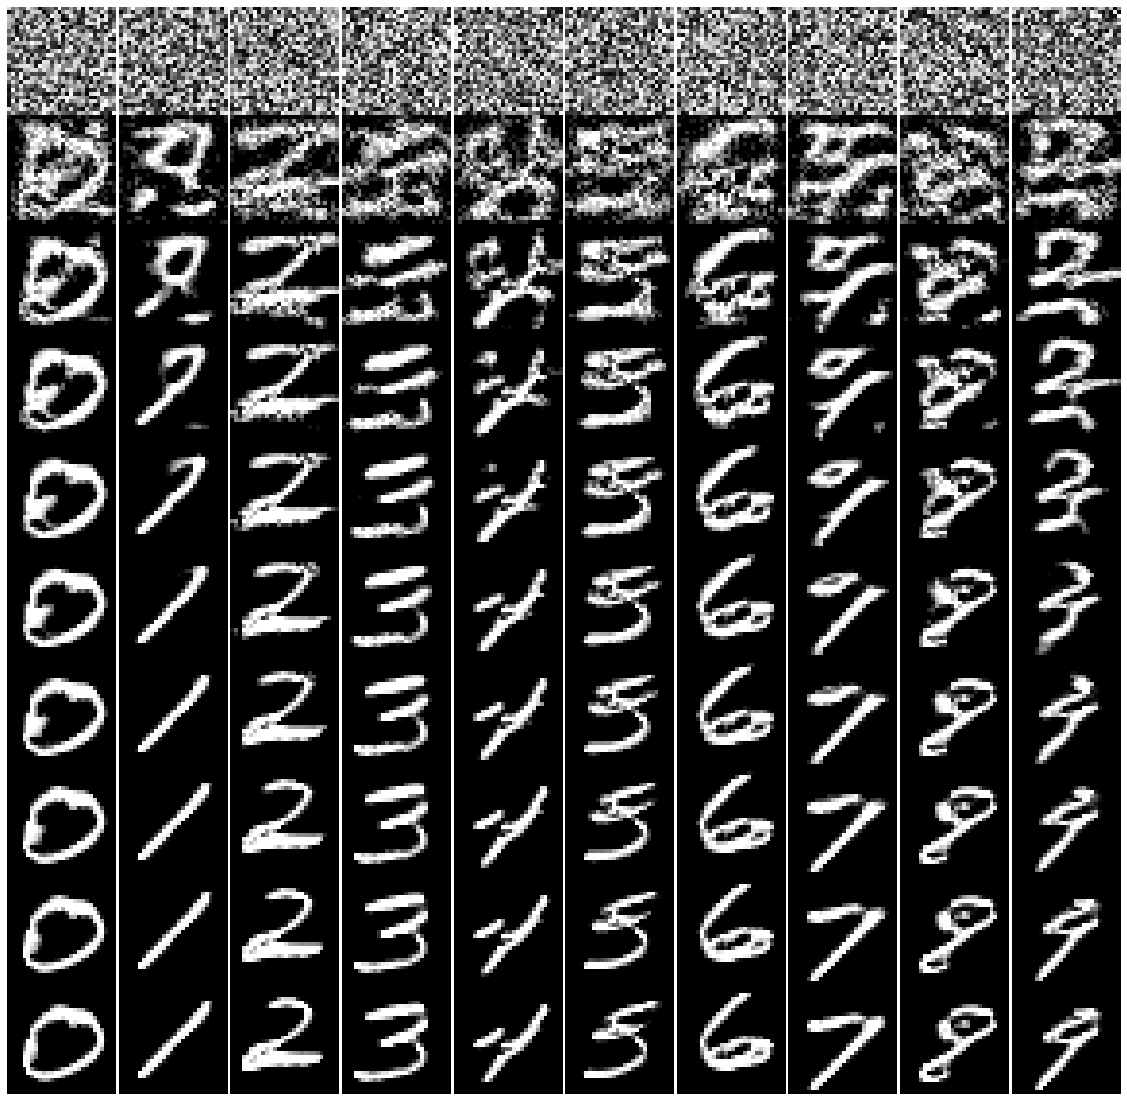

In [15]:
STEPS = 15
input_shape = [10, 1, 28, 28]
# Start with 20 steps, random noise, 
#y = torch.LongTensor([3]*10).to(device)
y = torch.arange(10).to(device) if CONDITIONAL else None
x_sample = [None] * 10
x_sample[0] = sample(net, [], input_shape, lambdaa, sigma, device, y,  0)
x_sample[1] = sample(net, [], input_shape, lambdaa, sigma, device, y,  STEPS, x0=x_sample[0])
for i in range(2, 10):
    x_sample[i] = sample(net, [], input_shape, lambdaa, sigma, device, y, n_steps=STEPS, x0=x_sample[i - 1])

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(x_sample[i][j].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig(image_path + 'ebm_mnist_num_gen.png', bbox_inches='tight', dpi=300)

### Cross-class transformation

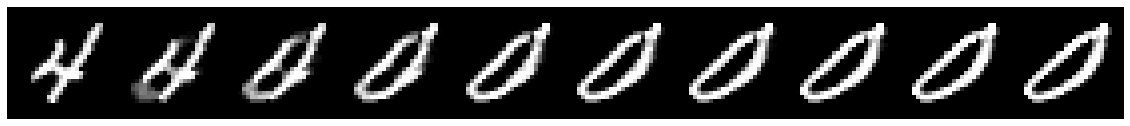

In [82]:
x_inputs, y_labels = next(iter(train_loader))
x_input = x_inputs[9].to(device)
y_label = y_labels[9]
input_shape = [1, 1, 28, 28]
output_label = torch.LongTensor([[0]]).to(device)
x_sample = [None] * 10
x_sample[0] = x_input[None, ...]
STEPS = 10
for i in range(1, 10):
    x_sample[i] = sample(net, [], input_shape, lambdaa, sigma, device, output_label, n_steps=STEPS, x0=x_sample[i - 1])

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_sample[i].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1) 

## **IMAGE COMPLETION**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(7, device='cuda:0')
torch.Size([1, 28, 28])


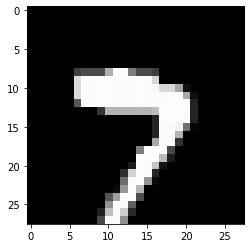

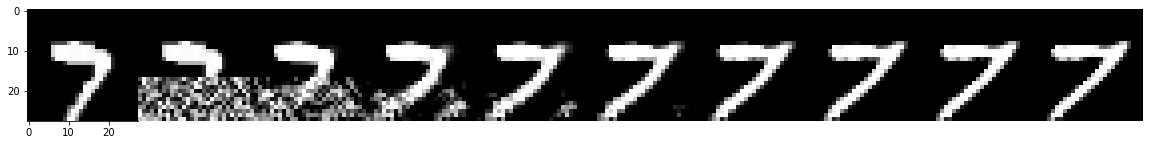

In [74]:
image_idx = np.random.randint(len(mnist_train))
x, y = mnist_train[image_idx]
x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device) if CONDITIONAL else None
print(y)
mask_proportion = 0.4
mask_length = int(x.shape[1]*mask_proportion)

bottom_mask_shape = torch.Size((x.shape[0], mask_length, x.shape[2]))
random_mask = torch.FloatTensor(bottom_mask_shape).uniform_(0., 1.)
plt.figure()
plt.imshow(x.view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)
x_masked = x.clone().detach()


x_masked[:, x.shape[1]- mask_length:, :] = random_mask

print(x_masked.shape)
input_shape = [1, 1, 28, 28]
output_label = torch.LongTensor([[1]]).to(device)
x_sample = [None] * 10
x_sample[0] = x_masked[None, ...].to(device)
x_masked.shape

STEPS = 10
for i in range(1, 10):
    x_sample[i] = sample(net, [], input_shape, lambdaa, sigma, device, y, n_steps=STEPS, x0=x_sample[i - 1])

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
plt.subplot(1, 10, 1)
plt.imshow(x.view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)
for i in range(9):
    plt.subplot(1, 10, i+2)
    plt.axis('off')
    plt.imshow(x_sample[i].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1) 
